# Benchmark Report for ASDF, HDF5, and FITS
*prepared by Jean-Christophe Malapert with the help of Guy Rixon*

## Purpose:

The purpose of this report is to compare the performance of the file formats ASDF, HDF5, and FITS for storing and reading scientific data.
The benchmarks were run on a machine with an Intel(R) Core(TM) i7-4710MQ CPU @ 2.50GHz CPU and 16GB of RAM running Ubuntu 22.04.1 LTS with Python

In [1]:
!python --version

Python 3.10.6


## Summary
- 1 - Methods
- 2 - Installation
- 3 - Code for benchmarking
- 3.1 - The code for storing the results
- 3.2 - The function for defining the ellapsed time
- 3.3 - The function for defining the filesize
- 4 - Data generation
- 4.1 - Mock DP2 provided by Guy Rixon (Sort of metadata - No binary data)
- 4.2 - dp2 in FITS, ASDF, HDF5
- 4.2.1 - Writing function
- 4.2.2 - Reading function
- 4.3 - Small Dataset (Binary data)
- 4.3.1 - Reading function
- 4.3.3 - Writing
- 4.4 - Large Dataset (Binary data)
- 4.4.1 - Reading function
- 4.4.2 - Writing function
- 5 - Running the benchmark
- 5.1 - Reading
- 5.2 - Writing
- 6 - Analysis
- 7 - Conclusion


## 1 - Methods:

Three test cases were used to evaluate the performance of each file format: storing DP2 product, storing a small dataset, storing a large dataset, and reading DP2, a small and a large dataset
- DP2 is a mock product from EAS, provided by Guy.
- The small dataset consisted of a time series of 100 points.
- The large dataset consisted of a time series of 1000000 points.
- The test cases were run 100 times for each file format, and the average time taken was recorded.

## 2 - Installation

In [2]:
try:
    import hdfdict
except:
    !pip install hdfdict
import json
try:
    import h5py
except:
    !pip install h5py
try:
    from astropy.io import fits
except:
    !pip install astropy
import numpy as np
try:
    import asdf
except:
    !pip install asdf
try:
    from deepdiff import DeepDiff
except:
    !pip install deepdiff
try:
    import pandas as pd
except:
    !pip install pandas
try:
    import matplotlib
except:
    !pip install matplotlib
from IPython.display import Markdown as md

## 3 - Code for benchmarking
This chapter groups together the different codes that are used to benchmark the different codes

### 3.1 - The code for storing the results

In [3]:
from enum import Enum

class DataEnum(str, Enum):

    DP2 = 'DP2'
    SMALL_DATASET = 'SMALL_DATASET'
    LARGE_DATASET = 'LARGE_DATASET'

    def __str__(self) -> str:
        return self.value

class FormatEnum(str, Enum):

    FITS = 'FITS'
    HDF5 = 'HDF5'
    HDF5_HDICT = 'HDF5_HDICT'
    HDF5_GUY = 'HDF5_GUY'
    ASDF = 'ASDF'

    def __str__(self) -> str:
        return self.value
    
class CriteriaEnum(str, Enum):

    SPEED_READ = 'SPEED_READ'
    SPEED_WRITE = 'SPEED_WRITE'
    STORING = 'STORING'

    def __str__(self) -> str:
        return self.value    

class AddResult:
    
    def __init__(self):
        self.results = dict()
        for format_file in FormatEnum:
            self.results[format_file.value] = dict()
            for criteria in CriteriaEnum:
                self.results[format_file.value][criteria.value] = dict()
                for data in DataEnum:
                    self.results[format_file.value][criteria.value][data.value] = None
        
    def save(self, format_file: FormatEnum, criteria: CriteriaEnum, data: DataEnum, value: float):
        self.results[str(format_file)][str(criteria)][str(data)] = value
        
add_results = AddResult()

### 3.2 - The function for defining the ellapsed time

The Python decorator function that can be used to time a function over a specified number of repeated executions. The decorator takes an optional parameter number, which defaults to 100. This fonction disables the garbage collector, records the start time, then calls the original function func the specified number of times, and records the end time. It then calculates the elapsed time and prints it out, as well as the mean elapsed time per run. Finally, it returns the original function's return value and the elapsed time.

In [4]:
import functools
import time
import gc

def timing(number=100):
    """Decorator that times the function it wraps over repeated executions

    Parameters
    ----------
    number : int
        The number of repeated executions of the function being wrapped
    Returns
    -------
    func
    """
    def actual_wrapper(func):
        @functools.wraps(func)
        def wrapper_timer(*args, **kwargs):
            # Temporarily turn off garbage collection during the timing.
            # Makes independent timings more comparable.
            # If it was originally enabled, switch it back on afterwards.            
            gcold = gc.isenabled()
            gc.disable()  
            try:          
                tic = time.perf_counter()
                for i in range(number - 1):
                    func(*args, **kwargs)
                else:
                    value = func(*args, **kwargs)
                toc = time.perf_counter()
                elapsed_time = toc - tic
                print(f"\nElapsed time of {func.__name__} for {number} runs:\n"
                    f" {elapsed_time:0.6f} seconds")
                print(f"Mean Elapsed time of {func.__name__}:\n"
                    f" {(elapsed_time/number):0.3f} seconds")                
            finally:
                if gcold:
                    gc.enable()            
            return value, elapsed_time
        return wrapper_timer
    return actual_wrapper

### 3.3 - The function for defining the filesize

This Python decorator function is used to get the file size of a file specified by the filename passed in as an argument.

In [5]:
import os
def sizing(filename):
    def actual_wrapper(func):
        @functools.wraps(func)
        def wrapper_timer(*args, **kwargs):
            value = func(*args, **kwargs)
            file_stats = os.stat(filename)
            print(f'File Size of {filename} is {file_stats.st_size} Bytes')                                   
            return value, file_stats.st_size
        return wrapper_timer
    return actual_wrapper

###  3.4 - Mock DP2 provided by Guy Rixon (Sort of metadata - No binary data)

This mock DP2 has been created by Guy Rixon to make a benchmark between HDF5, FITS, ASDF

In [6]:
from typing import Dict, List, Tuple
def mock_dp2() -> Tuple[List, Dict]:
    """
    Mocks a set of DP2 data.
    These are arranged as a list of TCE descriptions, each such description
    being a dictionary of parts.
    """
    dp2 = []

    tce1 = {
        'id' : '1',
        'star': '1',
        'ntransit': 3,
        'neclipse': 0,
        'period': 120.0,
        'epoch': 2461406.5,
        'phasepresent': False,
        'phasemetric': 0.001,
        'phasesignificance': 0.0,
        'ttvpresent': False,
        'ttvmetric': 0.1,
        'ttvsignificance': 0.0,
        'tdvpresent': False,
        'tdvmetric': 0.1,
        'tdvsignificance': 0.0,
        'cause': 'planet',
        'ldu1': 0.5,
        'ldu2': 0.25,
        'status': 'P',
        'vplanet': 0.73,
        'vephemeris': 0.9,
        'vconsistency': 0.9,
        'vbackground': 0.9,
        'grade': 'B',
        'planetprobability': 0.68,
        'confirmedplanet': False,
        'eclipses': [
            {
                'id': 1,
                'kind': 'T',
                'timestamp': 2461406.5,
                'depth': 0.95,
                'duration': 0.1
            },
            {
                'id': 2,
                'kind': 'T',
                'timestamp': 2461526.5,
                'depth': 0.95,
                'duration': 0.1
            },
            {
                'id': 3,
                'kind': 'T',
                'timestamp': 2461646.5,
                'depth': 0.95,
                'duration': 0.1
            },
        ],
        'bodies': [
            {
                'target': '1',
                'serial': 1,
                'planet': None,
                'kind': 'planetary candidate',
                'period': 120,
                'epoch': 2461406.5,
                'eccentricity': 0.0,
                'pephemeris': 0.95,
                'temperature': 300,
                'star_density': None
            }
        ]
    }

    tce2 = {
        'id': '2',
        'star': '2',
        'ntransit': 3,
        'neclipse': 0,
        'period': 120.0,
        'epoch': 2461406.5,
        'phasepresent': False,
        'phasemetric': 0.001,
        'phasesignificance': 0.0,
        'ttvpresent': True,
        'ttvmetric': 0.4,
        'ttvsignificance': 0.8,
        'tdvpresent': False,
        'tdvmetric': 0.1,
        'tdvsignificance': 0.0,
        'cause': 'planet',
        'ldu1': 0.5,
        'ldu2': 0.25,
        'status': 'P',
        'vplanet': 0.73,
        'vephemeris': 0.9,
        'vconsistency': 0.9,
        'vbackground': 0.9,
        'grade': 'A',
        'planetprobability': 0.98,
        'confirmedplanet': True,
        'eclipses': [
            {
                'id': 1,
                'kind': 'T',
                'timestamp': 2461406.5,
                'depth': 0.95,
                'duration': 0.1
            },
            {
                'id': 2,
                'kind': 'T',
                'timestamp': 2461526.5,
                'depth': 0.95,
                'duration': 0.1
            },
            {
                'id': 3,
                'kind': 'T',
                'timestamp': 2461646.5,
                'depth': 0.95,
                'duration': 0.1
            },
        ],
        'bodies': [
            {
                'target': '2',
                'serial': 1,
                'planet': 'a',
                'kind': 'confirmed planet',
                'period': 120,
                'epoch': 2461406.5,
                'eccentricity': 0.0,
                'pephemeris': 0.95,
                'temperature': 300,
                'star_density': None
            },
            {
                'target': '2',
                'serial': 3,
                'planet': 'a',
                'kind': 'perturbing planet',
                'period': 600,
                'epoch': 2461406.5,
                'eccentricity': 0.0,
                'pephemeris': 0.95,
                'temperature': 200,
                'star_density': None
            }
        ]
    }

    tce3 = {
        'id': '3',
        'star': '2',
        'ntransit': 2,
        'neclipse': 0,
        'period': 220.0,
        'epoch': 2461406.5,
        'phasepresent': False,
        'phasemetric': 0.001,
        'phasesignificance': 0.0,
        'ttvpresent': True,
        'ttvmetric': 0.4,
        'ttvsignificance': 0.8,
        'tdvpresent': True,
        'tdvmetric': 0.4,
        'tdvsignificance': 5.0,
        'cause': 'planet',
        'ldu1': 0.5,
        'ldu2': 0.25,
        'status': 'P',
        'vplanet': 0.73,
        'vephemeris': 0.9,
        'vconsistency': 0.9,
        'vbackground': 0.9,
        'grade': 'A',
        'planetprobability': 0.95,
        'confirmedplanet': True,
        'eclipses': [
            {
                'id': 1,
                'kind': 'T',
                'timestamp': 2461406.5,
                'depth': 0.95,
                'duration': 0.1
            },
            {
                'id': 2,
                'kind': 'T',
                'timestamp': 2461626.5,
                'depth': 0.95,
                'duration': 0.1
            },
        ],
        'bodies': [
            {
                'target': '2',
                'serial': 2,
                'planet': 'b',
                'kind': 'confirmed planet',
                'period': 220,
                'epoch': 2461406.5,
                'eccentricity': 0.0,
                'pephemeris': 0.95,
                'temperature': 150,
                'star_density': None
            },
            {
                'target': '2',
                'serial': 3,
                'planet': 'a',
                'kind': 'perturbing planet',
                'period': 600,
                'epoch': 2461406.5,
                'eccentricity': 0.0,
                'pephemeris': 0.95,
                'temperature': 200,
                'star_density': None
            }
        ]
    }

    tce5 = {
        'id': '5',
        'star': '4',
        'ntransit': 2,
        'neclipse': 0,
        'period': 220.0,
        'epoch': 2461406.5,
        'phasepresent': False,
        'phasemetric': 0.000,
        'phasesignificance': 0.0,
        'ttvpresent': False,
        'ttvmetric': 0.001,
        'ttvsignificance': 0.8,
        'tdvpresent': False,
        'tdvmetric': 0.0001,
        'tdvsignificance': 0,
        'cause': 'eclipsing binary',
        'ldu1': 0.5,
        'ldu2': 0.25,
        'status': 'A',
        'vplanet': 0.0,
        'vephemeris': 0.9,
        'vconsistency': 0.01,
        'vbackground': 0.9,
        'grade': None,
        'planetprobability': 0.0,
        'confirmedplanet': False,
        'eclipses': [
            {
                'id': 1,
                'kind': 'T',
                'timestamp': 2461406.5,
                'depth': 0.95,
                'duration': 0.1
            },
            {
                'id': 2,
                'kind': 'T',
                'timestamp': 2461626.5,
                'depth': 0.95,
                'duration': 0.1
            },
        ],
        'bodies': [
            {
                'target': '4',
                'serial': 1,
                'planet': None,
                'kind': 'companion star',
                'period': 220,
                'epoch': 2461406.5,
                'eccentricity': 0.0,
                'pephemeris': 0.95,
                'temperature': 4000,
                'star_density': None
            },
        ]
    }

    tce4 = {
        'id': '4',
        'star': '3',
        'ntransit': 2,
        'neclipse': 0,
        'period': 220.0,
        'epoch': 2461406.5,
        'phasepresent': False,
        'phasemetric': 0.000,
        'phasesignificance': 0.0,
        'ttvpresent': False,
        'ttvmetric': 0.001,
        'ttvsignificance': 0.8,
        'tdvpresent': False,
        'tdvmetric': 0.0001,
        'tdvsignificance': 0,
        'cause': 'instrumental noise',
        'ldu1': 0.5,
        'ldu2': 0.25,
        'status': 'I',
        'vplanet': 0.0,
        'vephemeris': 0.9,
        'vconsistency': 0.01,
        'vbackground': 0.9,
        'grade': None,
        'planetprobability': 0.0,
        'confirmedplanet': False,
        'eclipses': [
            {
                'id': 1,
                'kind': 'T',
                'timestamp': 2461406.5,
                'depth': 0.95,
                'duration': 0.1
            },
            {
                'id': 2,
                'kind': 'T',
                'timestamp': 2461626.5,
                'depth': 0.95,
                'duration': 0.1
            },
        ],
        'bodies': []
    }

    
    dp2.append(tce1)
    dp2.append(tce2)
    dp2.append(tce3)
    dp2.append(tce4)
    dp2.append(tce5)
    
    dp2_dict = {
        'tce1':tce1,
        'tce2':tce2,
        'tce3':tce3,
        'tce4':tce4,
        'tce5':tce5
    }

    return (dp2, dp2_dict)

## 4 - Data generation (the tests)

The following sections describes the functions that will be run in the benchmark.

### 4.1 - dp2 in FITS, ASDF, HDF5
This section provides the codes to write and read DP2 in FITS, ASDF and HDF5.
**Note** : Three implementations are provided for HDF5 :
- the original one from Guy Rixon using the different group of the HDF5
- a second one equivalent to Guy but using a python library and doing some optimization
- a third one where the dictionary is stored in one single dataset as a JSON representation.

#### 4.1.1 - Writing

In [7]:
@sizing('dp2.fits')
@timing()
def write_dp2_as_fits(dp2: Dict):    
    ## Code provided by Guy
    def make_fits_eclipse_table(dp2: List) -> fits.BinTableHDU:
        """
        Makes the HDU for the table of transits/eclipses in memory.
        """
        id_data = []
        tceref_data = []
        kind_data = []
        timestamp_data = []
        duration_data = []
        depth_data = []

        for tce in dp2:
            tceref = tce['id']
            for eclipse in tce['eclipses']:
                id_data.append(eclipse['id'])
                tceref_data.append(tceref)
                kind_data.append(eclipse['kind'])
                timestamp_data.append(eclipse['timestamp'])
                duration_data.append(eclipse['duration'])
                depth_data.append(eclipse['depth'])

        return fits.BinTableHDU.from_columns([
            fits.Column(name='id', array=np.array(id_data), format='J'),
            fits.Column(name='tce', array=np.array(tceref_data), format='A16'),
            fits.Column(name='kind', array=np.array(kind_data), format='A'),
            fits.Column(name='timestamp', array=np.array(timestamp_data), format='D'),
            fits.Column(name='duration', array=np.array(duration_data), format='D'),
            fits.Column(name='depth', array=np.array(duration_data), format='E'),
        ], name='Eclipses')

    def make_fits_tce_table(dp2: List) -> fits.BinTableHDU:
        """
        Makes the HDU for the main table of TCE details in memory.
        """

        # Make an array for each scalar item in the top level of the
        # tree of TCE details. Explicitly exclude keys that are sub-trees.
        column_names = list(dp2[0].keys())
        column_names.remove('eclipses')
        column_names.remove('bodies')
        column_data = {}
        for name in column_names:
            column_data[name] = []
        for tce in dp2:
            for name in column_names:
                column_data[name].append(tce[name])


        return fits.BinTableHDU.from_columns([
            fits.Column(name='id', array=np.array(column_data['id']), format='A16'),
            fits.Column(name='star', array=np.array(column_data['star']), format='A16'),
            fits.Column(name='ntransit', array=np.array(column_data['ntransit']), format='J'),
            fits.Column(name='neclipse', array=np.array(column_data['neclipse']), format='J'),
            fits.Column(name='period', array=np.array(column_data['period']), format='D'),
            fits.Column(name='epoch', array=np.array(column_data['epoch']), format='D'),
            fits.Column(name='phasepresent', array=np.array(column_data['phasepresent']), format='L'),
            fits.Column(name='phasemetric', array=np.array(column_data['phasemetric']), format='D'),
            fits.Column(name='phasesignificance', array=np.array(column_data['phasesignificance']), format='D'),
            fits.Column(name='ttvpresent', array=np.array(column_data['ttvpresent']), format='L'),
            fits.Column(name='ttvmetric', array=np.array(column_data['ttvmetric']), format='D'),
            fits.Column(name='ttvsignificance', array=np.array(column_data['ttvsignificance']), format='D'),
            fits.Column(name='tdvpresent', array=np.array(column_data['tdvpresent']), format='L'),
            fits.Column(name='tdvmetric', array=np.array(column_data['tdvmetric']), format='D'),
            fits.Column(name='tdvsignificance', array=np.array(column_data['tdvsignificance']), format='D'),
            fits.Column(name='cause', array=np.array(column_data['cause']), format='A16'),
            fits.Column(name='ldu1', array=np.array(column_data['ldu1']), format='D'),
            fits.Column(name='ldu2', array=np.array(column_data['ldu2']), format='D'),
            fits.Column(name='status', array=np.array(column_data['status']), format='A'),
            fits.Column(name='vplanet', array=np.array(column_data['vplanet']), format='D'),
            fits.Column(name='vephemeris', array=np.array(column_data['vephemeris']), format='D'),
            fits.Column(name='vconsistency', array=np.array(column_data['vconsistency']), format='D'),
            fits.Column(name='vbackground', array=np.array(column_data['vbackground']), format='D'),
            fits.Column(name='grade', array=np.array(column_data['grade']), format='A'),
            fits.Column(name='planetprobability', array=np.array(column_data['planetprobability']), format='D'),
            fits.Column(name='confirmedplanet', array=np.array(column_data['confirmedplanet']), format='L'),
        ], name='TCEs')    

    def make_fits_body_table(dp2: List) -> fits.BinTableHDU:
        """
        Makes the HDU for the table of bodies in memory.
        """
        id_data = []
        tceref_data = []
        target_data = []
        serial_data = []
        planet_data = []
        kind_data = []
        timestamp_data = []
        period_data = []
        epoch_data = []
        eccentricity_data = []
        pephemeris_data = []
        temperature_data = []
        star_density_data = []

        for tce in dp2:
            tceref = tce['id']
            for body in tce['bodies']:
                id = str(body['target']) + '.' + str(body['serial'])
                id_data.append(id)
                tceref_data.append(tceref)
                target_data.append(body['target'])
                serial_data.append(body['serial'])
                planet_letter = body['planet']
                if not planet_letter:
                    planet_letter = ''
                planet_data.append(planet_letter)
                kind_data.append(body['kind'])
                period_data.append(body['period'])
                epoch_data.append(body['epoch'])
                eccentricity_data.append(body['eccentricity'])
                temperature_data.append(body['temperature'])
                star_density_data.append(body['star_density'])

        return fits.BinTableHDU.from_columns([
            fits.Column(name='id', array=np.array(id_data), format='A18'),
            fits.Column(name='tce', array=np.array(tceref_data), format='A16'),
            fits.Column(name='target', array=np.array(target_data), format='A16'),
            fits.Column(name='serial', array=np.array(serial_data), format='J'),
            fits.Column(name='planet', array=np.array(planet_data), format='A'),
            fits.Column(name='kind', array=np.array(kind_data), format='A'),
            fits.Column(name='epoch', array=np.array(epoch_data), format='D'),
            fits.Column(name='period', array=np.array(period_data), format='D'),
            fits.Column(name='eccentricity', array=np.array(eccentricity_data), format='E'),
            fits.Column(name='temperature', array=np.array(temperature_data), format='E'),
            fits.Column(name='star_density', array=np.array(star_density_data), format='E'),
        ], name='Bodies')


    """
    Writes an example of DP2 into a FITS file.
    The data are stored as binary tables in a normalised,
    relational structure. One file is produced holding data
    for multiple TCEs spanning multiple, Plato targets.
    """
    hdr = fits.Header()
    hdr['COMMENT'] = "Example of Plato DP2 stored in FITS tables.."
    primary_hdu = fits.PrimaryHDU(header=hdr)

    # Make a binary-table HDU for the TCE table.
    tce_hdu = make_fits_tce_table(dp2)

    # Make a binary-table HDU for all the transits and eclipses.
    eclipse_hdu = make_fits_eclipse_table(dp2)

    # Make a binary-table HDU for all the astronomical bodies.
    body_hdu = make_fits_body_table(dp2)

    # Assemble and persist the file.
    hdul = fits.HDUList([primary_hdu, tce_hdu, eclipse_hdu, body_hdu])
    hdul.writeto('dp2.fits', overwrite=True)

@sizing('dp2_guy.h5')
@timing()
def write_hdf5_hierarchy_guy_dp2(dp2: List):
    """
    Writes an example of DP2 into an HDF5 file.
    The data are stored as one group per TCE;
    no attempt is made to group the TCEs belonging to a
    particular Plato target.
    """
    def write_hdf5_attr(g, key, value):
        """
        Writes an attribute of an HDF5 group.
        If the given value is null, the attribute is not written.
        """
        if value:
            g.__setitem__(key, value)  
            
    with h5py.File('dp2_guy.h5','w') as f:
        for tce in dp2:

            # Each TCE is an HDF5 group.
            name = 'tce' + tce['id']
            tce_group = f.create_group(name)

            # Scalar attributes of the TCE become attributes of the group.
            for key, value in tce.items():
                if key != 'eclipses' and key != 'bodies':
                    write_hdf5_attr(tce_group, key, value)

            # Each eclipse in the TCE is a sub-group, and its parameters are attributes of that group.
            for eclipse in tce['eclipses']:
                name = 'eclipse' + str(eclipse['id'])
                eclipse_group = tce_group.create_group(name)
                for key, value in eclipse.items():
                    write_hdf5_attr(eclipse_group, key, value)

            # Each body in the TCE is a sub-group, and its parameters are attributes of that group.
            for body in tce['bodies']:
                name = 'body' + str(body['serial'])
                body_group = tce_group.create_group(name)
                for key, value in body.items():
                    write_hdf5_attr(body_group, key, value)

@sizing('dp2_dict.h5')
@timing()
def write_dp2_as_HDF5_using_hierarchy(dp2: Dict):
    fname = 'dp2_dict.h5'
    hdfdict.dump(dp2, fname, mode='w')

@sizing('dp2_dataset.h5')
@timing()
def write_dp2_as_HDF5_simple_dataset(dp2: Dict):
    # The data to stored is veryn simple - no binary data.
    # Here we want to store the dictionary as it.
    # For this, we need to serialize the dictionnary
    # we choose JSON.
    json_serialize = json.dumps(dp2)
    with h5py.File('dp2_dataset.h5', 'w') as file:
        str_type = h5py.special_dtype(vlen=str)
        ds = file.create_dataset('/tces', shape=(1,), dtype=str_type)
        ds[:] = json_serialize 

@sizing('dp2.asdf')
@timing()
def write_dp2_as_ASDF(dp2: Dict):
    # Based on Guy's code  
    f = asdf.AsdfFile(dp2)
    f.write_to('dp2.asdf')


#### 4.1.2 Reading

In [8]:
from typing import Any

@timing()
def read_dp2_as_fits(): 
    def convert_data_type(column_name, columns, row_value) -> Any:
        result: Any
        if columns[column_name].format in ['D','E']:
            result = float(row_value)
        elif columns[column_name].format in ['I','J','K']:
            result = int(row_value)
        elif columns[column_name].format == 'L':
            result = bool(row_value)
        elif columns[column_name].format.endswith('A'):
            result = str(row_value)
        else:
            raise Exception(f'Data type not supported: {columns[column_name].format}')
        return result
        
    hdul = fits.open('dp2.fits')
    tces = dict()
    eclipses = dict()
    bodies = dict()
    for hdu in hdul[1:]:
        if hdu.header['EXTNAME'] == 'TCES':
            column_names = hdu.columns.names
            for row_data in hdu.data:
                tce_dict = {column_name: convert_data_type(column_name, hdu.columns, row_data[column_name]) for column_name in column_names if column_name != 'tce'}
                tces[f"tce{row_data['id']}"] = tce_dict
        elif hdu.header['EXTNAME'] == 'ECLIPSES':
            column_names = hdu.columns.names
            for row_data in hdu.data:
                eclipse_dict = {column_name: convert_data_type(column_name, hdu.columns, row_data[column_name]) for column_name in column_names if column_name != 'tce'}
                tce_id = row_data['tce']
                if tce_id in eclipses:
                    eclipses[tce_id].append(eclipse_dict)
                else:
                    eclipses[tce_id] = list()                
        elif hdu.header['EXTNAME'] == 'BODIES':
            column_names = hdu.columns.names
            tce_id: str            
            for row_data in hdu.data:
                body_dict = {column_name: convert_data_type(column_name, hdu.columns, row_data[column_name]) for column_name in column_names if column_name != 'tce'}
                tce_id = row_data['tce']
                if tce_id in bodies:
                    bodies[tce_id].append(body_dict)
                else:
                    bodies[tce_id] = list()                 
        else:
            # should not happen execpted if the data structure change
            pass
    for tce_id in eclipses.keys():
        tces[f"tce{tce_id}"].update({'eclipses':eclipses[tce_id]})
    for tce_id in bodies.keys():
        tces[f"tce{tce_id}"].update({'bodies':bodies[tce_id]})
    return tces
        
@timing()    
def read_hdf5_hierarchy_guy_dp2():
    data = dict()
    def read_guy_storing(name, obj):
        # Split name by '/' to get the group hierarchy
        name_parts = name.split("/")
        # Create a reference to the current level of the dictionary
        d = data
        # Iterate over the name parts, creating nested dictionaries as needed
        for part in name_parts[:-1]:
            if part not in d:
                d[part] = dict()
            d = d[part]
        # Get the name of the item
        item_name = name_parts[-1]
        if isinstance(obj, h5py.Dataset):
            # This is a dataset
            d[item_name] = obj[()]
        else:
            # This is a group
            d[item_name] = dict()

    with h5py.File('dp2_guy.h5') as f:
        f.visititems(read_guy_storing)
    return data
    
@timing()
def read_dp2_as_HDF5_using_hierarchy():
    return dict(hdfdict.load('dp2_dict.h5', lazy=False))

@timing()    
def read_dp2_as_HDF5_simple_dataset():
    data = None
    with h5py.File('dp2_dataset.h5', 'r') as f:
        data = f['tces'][0].decode()
    data=json.loads(data)
    return data

@timing()
def read_dp2_as_ASDF():
    data = None
    with asdf.open("dp2.asdf") as f:
        data = f.tree
    return {
        'tce1' : data['tce1'],
        'tce2' : data['tce2'],
        'tce3' : data['tce3'],
        'tce4' : data['tce4'],
        'tce5' : data['tce5']
    }    

### 4.2 - Small Dataset (Binary data)
This section provides the code to store/read a small time series (flux and time) of length 100.

#### 4.2.1 -Writing

In [9]:
@sizing('small_timeseries.fits')
@timing()
def write_small_data_fits():
    # Generate some example data
    time = np.linspace(0, 10, 100)
    flux = np.sin(time) + np.random.normal(0, 0.1, 100)

    # Create a HDU (Header Data Unit) list
    hdu_list = fits.HDUList()

    # Create the primary HDU
    primary_hdu = fits.PrimaryHDU()
    hdu_list.append(primary_hdu)

    # Create a new HDU for the time and flux data
    data_hdu = fits.BinTableHDU.from_columns([fits.Column(name='time', format='D', array=time),
                                         fits.Column(name='flux', format='D', array=flux)])

    hdu_list.append(data_hdu)

    # Save the HDU list to a file
    hdu_list.writeto('small_timeseries.fits', overwrite=True)

@sizing('small_timeseries.h5')
@timing()
def write_small_data_hdf5():
    # Generate some example data
    time = np.linspace(0, 10, 100)
    flux = np.sin(time) + np.random.normal(0, 0.1, 100)

    # Create an hdf5 file
    with h5py.File("small_timeseries.h5", "w") as f:
        # Create a dataset to store the time and flux data
        dset = f.create_dataset("time_flux", (100, 2), dtype='f')
        dset[:, 0] = time
        dset[:, 1] = flux    

@sizing('small_timeseries.asdf')
@timing()
def write_small_data_asdf():
    # Generate some example data
    time = np.linspace(0, 10, 100)
    flux = np.sin(time) + np.random.normal(0, 0.1, 100)

    # Create an asdf file
    with asdf.AsdfFile() as af:
        af.tree = {'time': time, 'flux': flux}
        af.write_to("small_timeseries.asdf")

#### 4.2.2 - Reading


In [10]:
@timing()
def read_small_data_fits():
    hdul = fits.open('small_timeseries.fits')
    data = hdul[1].data
    
@timing()
def read_small_data_hdf5():
    # Read an hdf5 file
    with h5py.File("small_timeseries.h5", "r") as f:
        # Create a dataset to store the time and flux data
        dset = f['time_flux']
        time = dset[:, 0]
        flux = dset[:, 1]
        
@timing()
def read_small_data_asdf():
    with asdf.open("small_timeseries.asdf") as f:
        time = f.tree['time']
        flux = f.tree['flux']  

### 4.3 - Large Dataset (Binary data)
This section provides the code to store/read a small time series (flux and time) of length 1 000 000.

#### 4.3.1 -Writing

In [11]:
@sizing('timeseries_large.fits')
@timing()
def write_large_data_fits():
    # Generate some example data
    time = np.linspace(0, 100000, 1000000)
    flux = np.sin(time) + np.random.normal(0, 1000, 1000000)

    # Create a HDU (Header Data Unit) list
    hdu_list = fits.HDUList()

    # Create the primary HDU
    primary_hdu = fits.PrimaryHDU()
    hdu_list.append(primary_hdu)

    # Create a new HDU for the time and flux data
    data_hdu = fits.BinTableHDU.from_columns([fits.Column(name='time', format='D', array=time),
                                         fits.Column(name='flux', format='D', array=flux)])

    hdu_list.append(data_hdu)

    # Save the HDU list to a file
    hdu_list.writeto('timeseries_large.fits', overwrite=True)

@sizing('timeseries_large.h5')
@timing()
def write_large_data_hdf5():
    # Generate some example data
    time = np.linspace(0, 100000, 1000000)
    flux = np.sin(time) + np.random.normal(0, 1000, 1000000)

    # Create an hdf5 file
    with h5py.File("timeseries_large.h5", "w") as f:
        # Create a dataset to store the time and flux data
        dset = f.create_dataset("time_flux", (1000000, 2), dtype='f')        
        dset[:, 0] = time
        dset[:, 1] = flux    

@sizing('timeseries_large.asdf')
@timing()
def write_large_data_asdf():
    # Generate some example data
    time = np.linspace(0, 100000, 1000000)
    flux = np.sin(time) + np.random.normal(0, 1000, 1000000)

    # Create an asdf file
    with asdf.AsdfFile() as af:
        af.tree = {'time': time, 'flux': flux}
        af.write_to("timeseries_large.asdf")

#### 4.3.2 - Reading


In [12]:
@timing()
def read_large_data_fits():
    hdul = fits.open('timeseries_large.fits')
    data = hdul[1].data
    
@timing()
def read_large_data_hdf5():
    # Read an hdf5 file
    with h5py.File("timeseries_large.h5", "r") as f:
        # Create a dataset to store the time and flux data
        dset = f['time_flux']
        time = dset[:, 0]
        flux = dset[:, 1]
        
@timing()
def read_large_data_asdf():
    with asdf.open("small_timeseries.asdf", mode="r") as f:
        time = f.tree['time']
        flux = f.tree['flux']
                

## 5 - Running the benchmark
This chapter executes the functions of chapter 4 for writing and reading data with the methods of chapter 3 for evaluating execution time and file size

### 5.1 - Writing the data
#### 5.1.1 -  Metadata (DP2)

In [13]:
dp2, dp2_dict = mock_dp2()

In [14]:
(_,speed_time),filesize = write_dp2_as_fits(dp2)
add_results.save(FormatEnum.FITS, CriteriaEnum.STORING, DataEnum.DP2, filesize)
add_results.save(FormatEnum.FITS, CriteriaEnum.SPEED_WRITE, DataEnum.DP2, speed_time)


Elapsed time of write_dp2_as_fits for 100 runs:
 3.709937 seconds
Mean Elapsed time of write_dp2_as_fits:
 0.037 seconds
File Size of dp2.fits is 23040 Bytes


In [15]:
(_,speed_time),filesize = write_hdf5_hierarchy_guy_dp2(dp2)
add_results.save(FormatEnum.HDF5_GUY, CriteriaEnum.STORING, DataEnum.DP2, filesize)
add_results.save(FormatEnum.HDF5_GUY, CriteriaEnum.SPEED_WRITE, DataEnum.DP2, speed_time)


Elapsed time of write_hdf5_hierarchy_guy_dp2 for 100 runs:
 4.234289 seconds
Mean Elapsed time of write_hdf5_hierarchy_guy_dp2:
 0.042 seconds
File Size of dp2_guy.h5 is 91872 Bytes


In [16]:
(_,speed_time),filesize = write_dp2_as_HDF5_using_hierarchy(dp2_dict)
add_results.save(FormatEnum.HDF5_HDICT, CriteriaEnum.STORING, DataEnum.DP2, filesize)
add_results.save(FormatEnum.HDF5_HDICT, CriteriaEnum.SPEED_WRITE, DataEnum.DP2, speed_time)


Elapsed time of write_dp2_as_HDF5_using_hierarchy for 100 runs:
 3.788440 seconds
Mean Elapsed time of write_dp2_as_HDF5_using_hierarchy:
 0.038 seconds
File Size of dp2_dict.h5 is 63088 Bytes


In [17]:
(_,speed_time),filesize = write_dp2_as_HDF5_simple_dataset(dp2_dict)
add_results.save(FormatEnum.HDF5, CriteriaEnum.STORING, DataEnum.DP2, filesize)
add_results.save(FormatEnum.HDF5, CriteriaEnum.SPEED_WRITE, DataEnum.DP2, speed_time)


Elapsed time of write_dp2_as_HDF5_simple_dataset for 100 runs:
 0.100035 seconds
Mean Elapsed time of write_dp2_as_HDF5_simple_dataset:
 0.001 seconds
File Size of dp2_dataset.h5 is 6880 Bytes


In [18]:
(_,speed_time),filesize = write_dp2_as_ASDF(dp2_dict)
add_results.save(FormatEnum.ASDF, CriteriaEnum.STORING, DataEnum.DP2, filesize)
add_results.save(FormatEnum.ASDF, CriteriaEnum.SPEED_WRITE, DataEnum.DP2, speed_time)


Elapsed time of write_dp2_as_ASDF for 100 runs:
 3.634706 seconds
Mean Elapsed time of write_dp2_as_ASDF:
 0.036 seconds
File Size of dp2.asdf is 4792 Bytes


#### 5.1.2 - Small dataset 

In [19]:
(_,speed_time),filesize = write_small_data_fits()
add_results.save(FormatEnum.FITS, CriteriaEnum.STORING, DataEnum.SMALL_DATASET, filesize)
add_results.save(FormatEnum.FITS, CriteriaEnum.SPEED_WRITE, DataEnum.SMALL_DATASET, speed_time)


Elapsed time of write_small_data_fits for 100 runs:
 0.416292 seconds
Mean Elapsed time of write_small_data_fits:
 0.004 seconds
File Size of small_timeseries.fits is 8640 Bytes


In [20]:
(_,speed_time),filesize = write_small_data_hdf5()
add_results.save(FormatEnum.HDF5, CriteriaEnum.STORING, DataEnum.SMALL_DATASET, filesize)
add_results.save(FormatEnum.HDF5, CriteriaEnum.SPEED_WRITE, DataEnum.SMALL_DATASET, speed_time)


Elapsed time of write_small_data_hdf5 for 100 runs:
 0.099935 seconds
Mean Elapsed time of write_small_data_hdf5:
 0.001 seconds
File Size of small_timeseries.h5 is 2848 Bytes


In [21]:
(_,speed_time),filesize = write_small_data_asdf()
add_results.save(FormatEnum.ASDF, CriteriaEnum.STORING, DataEnum.SMALL_DATASET, filesize)
add_results.save(FormatEnum.ASDF, CriteriaEnum.SPEED_WRITE, DataEnum.SMALL_DATASET, speed_time)


Elapsed time of write_small_data_asdf for 100 runs:
 16.796708 seconds
Mean Elapsed time of write_small_data_asdf:
 0.168 seconds
File Size of small_timeseries.asdf is 2358 Bytes


#### Large dataset 

In [22]:
(_,speed_time),filesize = write_large_data_fits()
add_results.save(FormatEnum.FITS, CriteriaEnum.STORING, DataEnum.LARGE_DATASET, filesize)
add_results.save(FormatEnum.FITS, CriteriaEnum.SPEED_WRITE, DataEnum.LARGE_DATASET, speed_time)


Elapsed time of write_large_data_fits for 100 runs:
 8.507706 seconds
Mean Elapsed time of write_large_data_fits:
 0.085 seconds
File Size of timeseries_large.fits is 16007040 Bytes


In [23]:
(_,speed_time),filesize = write_large_data_hdf5()
add_results.save(FormatEnum.HDF5, CriteriaEnum.STORING, DataEnum.LARGE_DATASET, filesize)
add_results.save(FormatEnum.HDF5, CriteriaEnum.SPEED_WRITE, DataEnum.LARGE_DATASET, speed_time)


Elapsed time of write_large_data_hdf5 for 100 runs:
 9.473741 seconds
Mean Elapsed time of write_large_data_hdf5:
 0.095 seconds
File Size of timeseries_large.h5 is 8002048 Bytes


In [24]:
(_,speed_time),filesize = write_large_data_asdf()
add_results.save(FormatEnum.ASDF, CriteriaEnum.STORING, DataEnum.LARGE_DATASET, filesize)
add_results.save(FormatEnum.ASDF, CriteriaEnum.SPEED_WRITE, DataEnum.LARGE_DATASET, speed_time)


Elapsed time of write_large_data_asdf for 100 runs:
 28.032213 seconds
Mean Elapsed time of write_large_data_asdf:
 0.280 seconds
File Size of timeseries_large.asdf is 16000769 Bytes


### 5.2 - Reading the data
#### 5.2.1 - Metadata (DP2)


In [25]:
result, speed_time = read_dp2_as_fits()
add_results.save(FormatEnum.FITS, CriteriaEnum.SPEED_READ, DataEnum.DP2, speed_time)


Elapsed time of read_dp2_as_fits for 100 runs:
 2.369735 seconds
Mean Elapsed time of read_dp2_as_fits:
 0.024 seconds


In [26]:
DeepDiff(dp2_dict,result, ignore_order=True)

{'type_changes': {"root['tce4']['tdvsignificance']": {'old_type': int,
   'new_type': float,
   'old_value': 0,
   'new_value': 0.0},
  "root['tce4']['grade']": {'old_type': NoneType,
   'new_type': str,
   'old_value': None,
   'new_value': 'N'},
  "root['tce5']['tdvsignificance']": {'old_type': int,
   'new_type': float,
   'old_value': 0,
   'new_value': 0.0},
  "root['tce5']['grade']": {'old_type': NoneType,
   'new_type': str,
   'old_value': None,
   'new_value': 'N'}},
 'dictionary_item_removed': [root['tce4']['bodies']],
 'values_changed': {"root['tce4']['cause']": {'new_value': 'instrumental noi',
   'old_value': 'instrumental noise'},
  "root['tce3']['bodies'][0]": {'new_value': {'id': '2.3',
    'target': '2',
    'serial': 3,
    'planet': 'a',
    'kind': 'p',
    'epoch': 2461406.5,
    'period': 600.0,
    'eccentricity': 0.0,
    'temperature': 200.0,
    'star_density': nan},
   'old_value': {'target': '2',
    'serial': 2,
    'planet': 'b',
    'kind': 'confirmed pla

**WARNING** : 
the result of the FITS file reading does not match the input DP2. This is due to multiple causes:
- the analysis tool is sensitive to the record order in the Hash => Ignore
- Problem of NaN management in FITS. The definition of the value corresponding to the NaN is missing in the FITS header
- Conversion problem. Indeed, the 'cause' parameter has been encoded as a string of 16 characters : *fits.Column(name='cause', array=np.array(column_data['cause']), format='A16')*. This works well for this entry:
*'cause': 'eclipsing binary'* or this one *'cause': 'planet'* but does not work for this one *'cause': 'instrumental noise'*. In the last case, the string is recorded in the FITS file as follows: *instrumental noi*
- same problem for 'kind':
      - definition: fits.Column(name='kind', array=np.array(kind_data), format='A') => encoding with one character
      - values to encode in the set of records: T, planetary candidate, perturbing planet
      - "planetary candidate" is truncated to "p" as well as "perturbing planet
- a problem of numerical precision
- personal feedback : To recreate the dictionary structure from the FITS file, it took some time to understand and code it (even though it is quite simple). And it still took a long time to investigate the problems. And after several hours, I realize that the information in the file was not correctly encoded. Note that if I had not compared the output of the FITS file with its input, I would never have known.

As a result, translating a simple dictionary into a FITS file can be a complex and very sensitive operation due to the developer's knowledge of his data. In the example here, we can see that the sample selected to determine the encoding was not represented, which caused a loss of data. And apparently, no warning from the FITS library about this problem, which is even more worrying !!!!

In operation, this problem can be very complicated to detect because the syntax of the format is good, it is the values that are not good and I do not see a simple way to solve this problem. In short, a high-risk operation that promises to consume a lot of time given the amount of data to manage

In [27]:
result, speeed_time = read_hdf5_hierarchy_guy_dp2()
add_results.save(FormatEnum.HDF5_GUY, CriteriaEnum.SPEED_READ, DataEnum.DP2, speed_time)


Elapsed time of read_hdf5_hierarchy_guy_dp2 for 100 runs:
 4.621963 seconds
Mean Elapsed time of read_hdf5_hierarchy_guy_dp2:
 0.046 seconds


In [28]:
DeepDiff(dp2_dict, result)

{'type_changes': {"root['tce1']['cause']": {'old_type': str,
   'new_type': bytes,
   'old_value': 'planet',
   'new_value': b'planet'},
  "root['tce1']['epoch']": {'old_type': float,
   'new_type': numpy.float64,
   'old_value': 2461406.5,
   'new_value': 2461406.5},
  "root['tce1']['grade']": {'old_type': str,
   'new_type': bytes,
   'old_value': 'B',
   'new_value': b'B'},
  "root['tce1']['id']": {'old_type': str,
   'new_type': bytes,
   'old_value': '1',
   'new_value': b'1'},
  "root['tce1']['ldu1']": {'old_type': float,
   'new_type': numpy.float64,
   'old_value': 0.5,
   'new_value': 0.5},
  "root['tce1']['ldu2']": {'old_type': float,
   'new_type': numpy.float64,
   'old_value': 0.25,
   'new_value': 0.25},
  "root['tce1']['ntransit']": {'old_type': int,
   'new_type': numpy.int64,
   'old_value': 3,
   'new_value': 3},
  "root['tce1']['period']": {'old_type': float,
   'new_type': numpy.float64,
   'old_value': 120.0,
   'new_value': 120.0},
  "root['tce1']['phasemetric']":

In [29]:
result, speed_time = read_dp2_as_HDF5_using_hierarchy()
add_results.save(FormatEnum.HDF5_HDICT, CriteriaEnum.SPEED_READ, DataEnum.DP2, speed_time)


Elapsed time of read_dp2_as_HDF5_using_hierarchy for 100 runs:
 4.500911 seconds
Mean Elapsed time of read_dp2_as_HDF5_using_hierarchy:
 0.045 seconds


In [30]:
DeepDiff(dp2_dict, result)

{'type_changes': {"root['tce1']['cause']": {'old_type': str,
   'new_type': bytes,
   'old_value': 'planet',
   'new_value': b'planet'},
  "root['tce1']['confirmedplanet']": {'old_type': bool,
   'new_type': numpy.bool_,
   'old_value': False,
   'new_value': False},
  "root['tce1']['epoch']": {'old_type': float,
   'new_type': numpy.float64,
   'old_value': 2461406.5,
   'new_value': 2461406.5},
  "root['tce1']['grade']": {'old_type': str,
   'new_type': bytes,
   'old_value': 'B',
   'new_value': b'B'},
  "root['tce1']['id']": {'old_type': str,
   'new_type': bytes,
   'old_value': '1',
   'new_value': b'1'},
  "root['tce1']['ldu1']": {'old_type': float,
   'new_type': numpy.float64,
   'old_value': 0.5,
   'new_value': 0.5},
  "root['tce1']['ldu2']": {'old_type': float,
   'new_type': numpy.float64,
   'old_value': 0.25,
   'new_value': 0.25},
  "root['tce1']['neclipse']": {'old_type': int,
   'new_type': numpy.int64,
   'old_value': 0,
   'new_value': 0},
  "root['tce1']['ntransit'

**WARNING** : These alerts can be ignored. The representation of the information is correct. 
For instance b'hello' is represented in the same way as 'hello' but the encoding is a bit different.
Example:
```
>>> b'hello' == 'hello'
False
>>> b'hello'.decode('utf-8') == 'hello'
True
```

In [31]:
result, speed_time = read_dp2_as_HDF5_simple_dataset()
add_results.save(FormatEnum.HDF5, CriteriaEnum.SPEED_READ, DataEnum.DP2, speed_time)


Elapsed time of read_dp2_as_HDF5_simple_dataset for 100 runs:
 0.088576 seconds
Mean Elapsed time of read_dp2_as_HDF5_simple_dataset:
 0.001 seconds


In [32]:
DeepDiff(dp2_dict, result)

{}

In [33]:
result,speed_time=read_dp2_as_ASDF()
add_results.save(FormatEnum.ASDF, CriteriaEnum.SPEED_READ, DataEnum.DP2, speed_time)


Elapsed time of read_dp2_as_ASDF for 100 runs:
 4.416067 seconds
Mean Elapsed time of read_dp2_as_ASDF:
 0.044 seconds


In [34]:
DeepDiff(dp2_dict, result)

{}

**Note** : No problem with ASDF and HDF5

#### 5.2.2 - Small Dataset

In [35]:
_, speed_time = read_small_data_fits()
add_results.save(FormatEnum.FITS, CriteriaEnum.SPEED_READ, DataEnum.SMALL_DATASET, speed_time)


Elapsed time of read_small_data_fits for 100 runs:
 0.186890 seconds
Mean Elapsed time of read_small_data_fits:
 0.002 seconds


In [36]:
_, speed_time = read_small_data_hdf5()
add_results.save(FormatEnum.HDF5, CriteriaEnum.SPEED_READ, DataEnum.SMALL_DATASET, speed_time)


Elapsed time of read_small_data_hdf5 for 100 runs:
 0.042333 seconds
Mean Elapsed time of read_small_data_hdf5:
 0.000 seconds


In [37]:
_, speed_time = read_small_data_asdf()
add_results.save(FormatEnum.ASDF, CriteriaEnum.SPEED_READ, DataEnum.SMALL_DATASET, speed_time)


Elapsed time of read_small_data_asdf for 100 runs:
 12.394501 seconds
Mean Elapsed time of read_small_data_asdf:
 0.124 seconds


#### 5.2.3 - Large Dataset

In [38]:
_, speed_time = read_large_data_fits()
add_results.save(FormatEnum.FITS, CriteriaEnum.SPEED_READ, DataEnum.LARGE_DATASET, speed_time)


Elapsed time of read_large_data_fits for 100 runs:
 0.226780 seconds
Mean Elapsed time of read_large_data_fits:
 0.002 seconds


In [39]:
_, speed_time = read_large_data_hdf5()
add_results.save(FormatEnum.HDF5, CriteriaEnum.SPEED_READ, DataEnum.LARGE_DATASET, speed_time)


Elapsed time of read_large_data_hdf5 for 100 runs:
 1.962823 seconds
Mean Elapsed time of read_large_data_hdf5:
 0.020 seconds


In [40]:
_, speed_time = read_large_data_asdf()
add_results.save(FormatEnum.ASDF, CriteriaEnum.SPEED_READ, DataEnum.LARGE_DATASET, speed_time)


Elapsed time of read_large_data_asdf for 100 runs:
 12.603467 seconds
Mean Elapsed time of read_large_data_asdf:
 0.126 seconds


## 6 - Analysis
This section analyzes the results of the benchmark

### 6.1 - Writing speed

In [41]:
data = {
    'FITS': add_results.results['FITS']['SPEED_WRITE'],
    'HDF5': add_results.results['HDF5']['SPEED_WRITE'],
    'HDF5_GUY': add_results.results['HDF5_GUY']['SPEED_WRITE'],
    'HDF5_HDICT': add_results.results['HDF5_HDICT']['SPEED_WRITE'],
    'ASDF': add_results.results['ASDF']['SPEED_WRITE']
}
df=pd.DataFrame.from_dict(data)

Displaying data

In [42]:
df

FITS      HDF5  HDF5_GUY  HDF5_HDICT       ASDF
DP2            3.709937  0.100035  4.234289     3.78844   3.634706
SMALL_DATASET  0.416292  0.099935       NaN         NaN  16.796708
LARGE_DATASET  8.507706  9.473741       NaN         NaN  28.032213

Plot representing the time (in s) spent to store = f(use case)

<AxesSubplot: ylabel='Time(s) spent to store'>

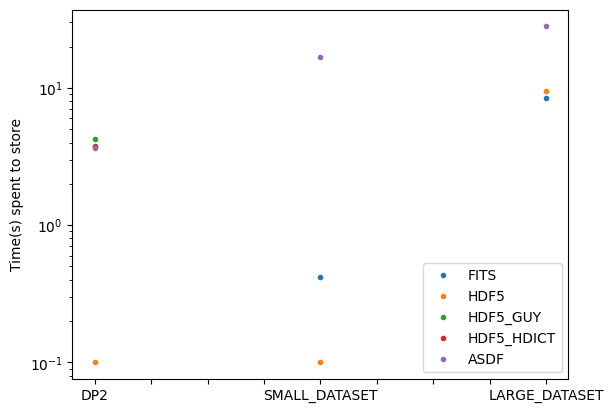

In [43]:
df.plot(ylabel='Time(s) spent to store', logy=True, marker='.', linestyle='none')

Ratio of time spent writing for each format to time spent by the best performing format

                    FITS      HDF5   HDF5_GUY  HDF5_HDICT        ASDF
DP2            37.086255  1.000000  42.327922   37.871016   36.334219
SMALL_DATASET   4.165638  1.000000        NaN         NaN  168.076623
LARGE_DATASET   1.000000  1.113548        NaN         NaN    3.294920


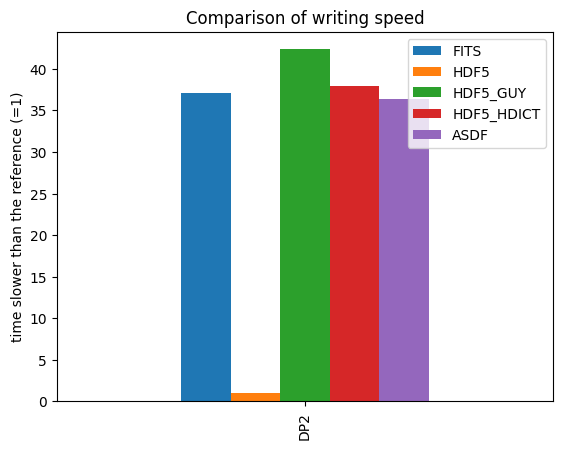

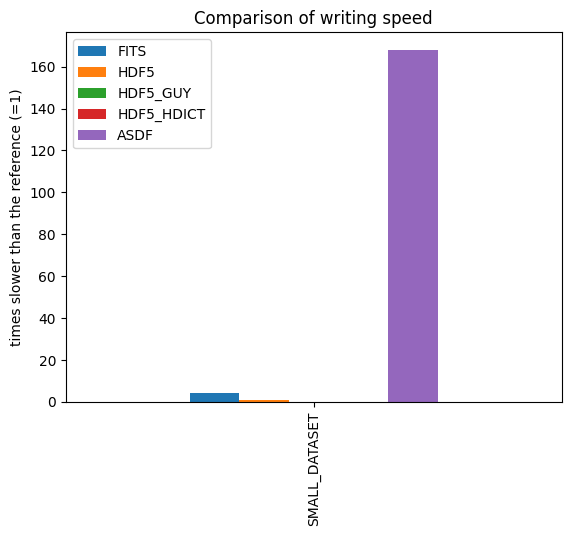

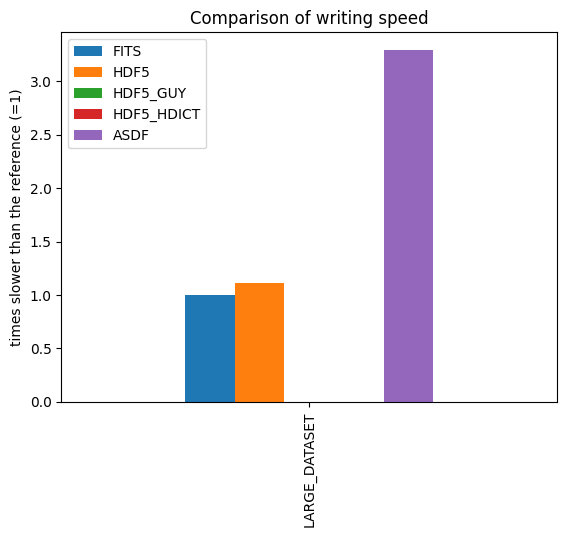

In [44]:
df['Dmin'] = df.min(axis=1)
df['Fmin'] = df.idxmin(axis=1)
for file_format in ['FITS', 'HDF5','HDF5_GUY','HDF5_HDICT', 'ASDF']:
    df[f'ratio_{file_format}'] = df[file_format]/df['Dmin']
df_ratio = df[['ratio_FITS','ratio_HDF5','ratio_HDF5_GUY','ratio_HDF5_HDICT','ratio_ASDF']]
df_ratio = df_ratio.rename(columns={
    "ratio_FITS": "FITS", 
    "ratio_HDF5": "HDF5", 
    "ratio_HDF5_GUY": "HDF5_GUY",
    "ratio_HDF5_HDICT":"HDF5_HDICT",
    "ratio_ASDF":"ASDF"})
df_ratio.loc[['DP2']][['FITS','HDF5','HDF5_GUY','HDF5_HDICT','ASDF']].plot(kind='bar', ylabel='time slower than the reference (=1)', title='Comparison of writing speed')
df_ratio.loc[['SMALL_DATASET']][['FITS','HDF5','HDF5_GUY','HDF5_HDICT','ASDF']].plot(kind='bar', ylabel='times slower than the reference (=1)', title='Comparison of writing speed')
df_ratio.loc[['LARGE_DATASET']][['FITS','HDF5','HDF5_GUY','HDF5_HDICT','ASDF']].plot(kind='bar', ylabel='times slower than the reference (=1)', title='Comparison of writing speed')
print(df_ratio)


In [45]:
md("**Note** : The way to encode the Python dictionary (DP2) as ASCII in a HDF5 is much better than other encodings. The encoding speed of the ASCII encoding in HDF5 is about {}x faster than other HDF5 encodings and other file formats. The explanation comes in the rest of the report.".format(int(df_ratio[['HDF5_GUY']].loc['DP2'])))

**Note** : The way to encode the Python dictionary (DP2) as ASCII in a HDF5 is much better than other encodings. The encoding speed of the ASCII encoding in HDF5 is about 42x faster than other HDF5 encodings and other file formats. The explanation comes in the rest of the report.

### 6.2 - Reading speed

In [46]:
data = {
    'FITS': add_results.results['FITS']['SPEED_READ'],
    'HDF5': add_results.results['HDF5']['SPEED_READ'], 
    'HDF5_GUY': add_results.results['HDF5_GUY']['SPEED_READ'],     
    'HDF5_HDICT': add_results.results['HDF5_HDICT']['SPEED_READ'],
    'ASDF': add_results.results['ASDF']['SPEED_READ']
}
df=pd.DataFrame.from_dict(data)

Displaying data

In [47]:
df

FITS      HDF5  HDF5_GUY  HDF5_HDICT       ASDF
DP2            2.369735  0.088576  2.369735    4.500911   4.416067
SMALL_DATASET  0.186890  0.042333       NaN         NaN  12.394501
LARGE_DATASET  0.226780  1.962823       NaN         NaN  12.603467

Plot representing the time (in s) spent to read = f(use case)

<AxesSubplot: ylabel='Time(s) spent to read'>

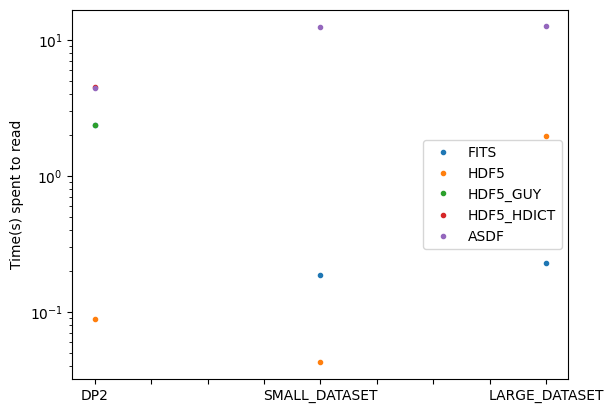

In [48]:
df.plot(ylabel='Time(s) spent to read', logy=True, marker='.', linestyle='none')

Ratio of time spent reading for each format to time spent by the best performing format

                    FITS      HDF5  HDF5_GUY  HDF5_HDICT        ASDF
DP2            26.753821  1.000000  2.369735   50.814354   49.856476
SMALL_DATASET   4.414701  1.000000       NaN         NaN  292.782393
LARGE_DATASET   1.000000  8.655184       NaN         NaN   55.575736


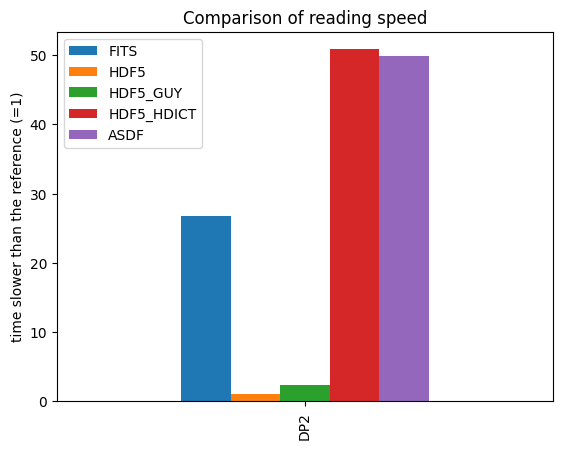

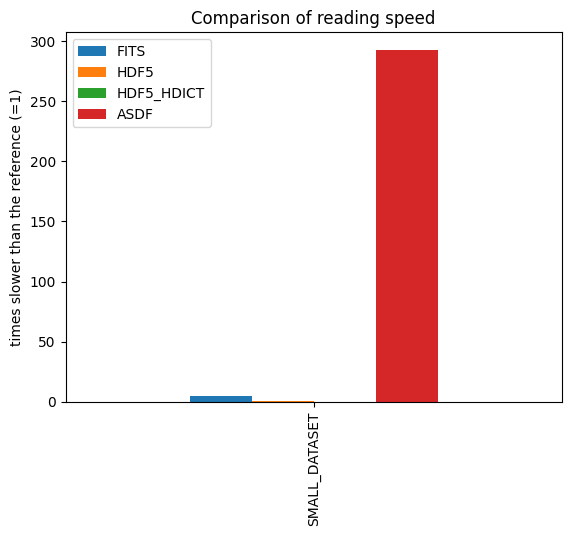

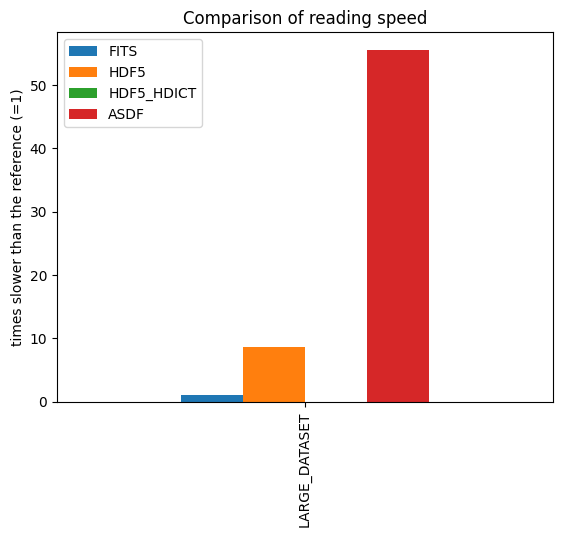

In [49]:
df['Dmin'] = df.min(axis=1)
df['Fmin'] = df.idxmin(axis=1)
for file_format in ['FITS', 'HDF5','HDF5_HDICT', 'ASDF']:
    df[f'ratio_{file_format}'] = df[file_format]/df['Dmin']
df_ratio = df[['ratio_FITS','ratio_HDF5','HDF5_GUY','ratio_HDF5_HDICT','ratio_ASDF']]
df_ratio = df_ratio.rename(columns={
    "ratio_FITS": "FITS", 
    "ratio_HDF5": "HDF5", 
    "ratio_HDF5_HDICT":"HDF5_HDICT",
    "ratio_ASDF":"ASDF"})
df_ratio.loc[['DP2']][['FITS','HDF5','HDF5_GUY','HDF5_HDICT','ASDF']].plot(kind='bar', ylabel='time slower than the reference (=1)', title='Comparison of reading speed')
df_ratio.loc[['SMALL_DATASET']][['FITS','HDF5','HDF5_HDICT','ASDF']].plot(kind='bar', ylabel='times slower than the reference (=1)', title='Comparison of reading speed')
df_ratio.loc[['LARGE_DATASET']][['FITS','HDF5','HDF5_HDICT','ASDF']].plot(kind='bar', ylabel='times slower than the reference (=1)', title='Comparison of reading speed')
print(df_ratio)


In [50]:
md("**Note** : The ASCII encoding of the HDF5 file for a Python dictionary (DP2) gives better results for reading the data than other HDF5 encodings or other formats. On average, this encoding is {}x better than FITS and {}x better than ASDF ou HDF5_DICT. For the cases of a small time series, normal HDF5 encoding is {}x better than FITS and {}x better than ASDF! For the cases of a large time series, FITS is better, {}x better that normal HDF5 encoding and {}x better than ASDF. The performance of ASDF is quite surprising in a bad way. There must surely be another way to encode a time series  to get better performances (at least something ~ FITS). To ask a specialist of the ASDF formatOn the other hand, if the chunks are used at the creation of the dataset by HDF5 and the compression as well, the reading performances should be equivalent to the FITS, or even better but at the expense of the space occupied on the disk. See notebook already presented : https://github.com/pdssp/FITS_HDF5".format(
   int(df_ratio[['FITS']].loc['DP2']),
   int(df_ratio[['ASDF']].loc['DP2']),
   int(df_ratio[['FITS']].loc['SMALL_DATASET']),
   int(df_ratio[['ASDF']].loc['SMALL_DATASET']),
   int(df_ratio[['HDF5']].loc['LARGE_DATASET']),
   int(df_ratio[['ASDF']].loc['LARGE_DATASET'])
))




**Note** : The ASCII encoding of the HDF5 file for a Python dictionary (DP2) gives better results for reading the data than other HDF5 encodings or other formats. On average, this encoding is 26x better than FITS and 49x better than ASDF ou HDF5_DICT. For the cases of a small time series, normal HDF5 encoding is 4x better than FITS and 292x better than ASDF! For the cases of a large time series, FITS is better, 8x better that normal HDF5 encoding and 55x better than ASDF. The performance of ASDF is quite surprising in a bad way. There must surely be another way to encode a time series  to get better performances (at least something ~ FITS). To ask a specialist of the ASDF formatOn the other hand, if the chunks are used at the creation of the dataset by HDF5 and the compression as well, the reading performances should be equivalent to the FITS, or even better but at the expense of the space occupied on the disk. See notebook already presented : https://github.com/pdssp/FITS_HDF5

### 6.3 - Filesize

In [51]:
data = {
    'FITS': add_results.results['FITS']['STORING'],
    'HDF5': add_results.results['HDF5']['STORING'],
    'HDF5_GUY': add_results.results['HDF5_GUY']['STORING'],
    'HDF5_HDICT': add_results.results['HDF5_HDICT']['STORING'],
    'ASDF': add_results.results['ASDF']['STORING']
}
df=pd.DataFrame.from_dict(data)

Displaying data

In [52]:
df

FITS     HDF5  HDF5_GUY  HDF5_HDICT      ASDF
DP2               23040     6880   91872.0     63088.0      4792
SMALL_DATASET      8640     2848       NaN         NaN      2358
LARGE_DATASET  16007040  8002048       NaN         NaN  16000769

Plot representing the space occupied on the disk (Bytes) = f(use case)

<AxesSubplot: ylabel='Space occupied on the disk (Bytes)'>

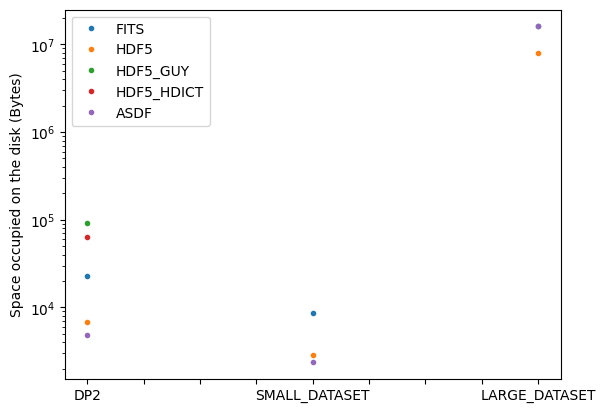

In [53]:
df.plot(ylabel='Space occupied on the disk (Bytes)', logy=True, marker='.', linestyle='none')

                   FITS      HDF5   HDF5_GUY  HDF5_HDICT      ASDF
DP2            4.808013  1.435726  19.171953   13.165275  1.000000
SMALL_DATASET  3.664122  1.207803        NaN         NaN  1.000000
LARGE_DATASET  2.000368  1.000000        NaN         NaN  1.999584


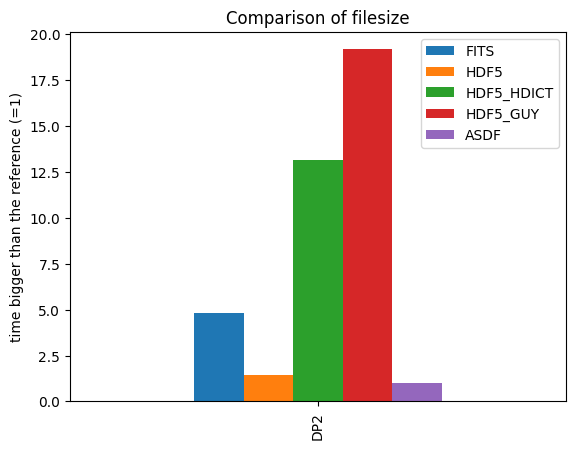

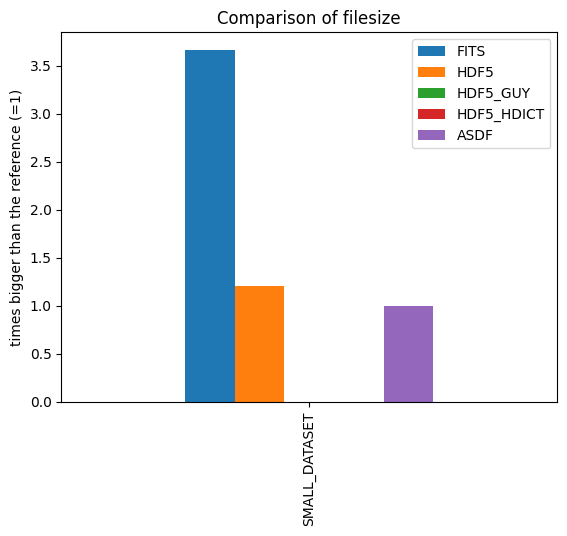

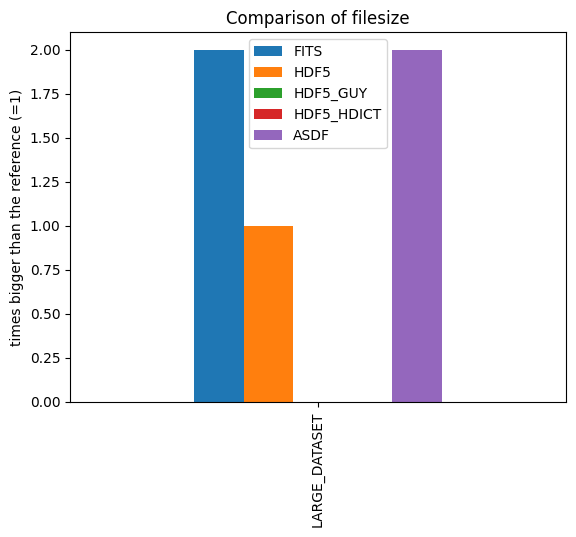

In [54]:
df['Dmin'] = df.min(axis=1)
df['Fmin'] = df.idxmin(axis=1)
for file_format in ['FITS', 'HDF5','HDF5_GUY','HDF5_HDICT', 'ASDF']:
    df[f'ratio_{file_format}'] = df[file_format]/df['Dmin']
df_ratio = df[['ratio_FITS','ratio_HDF5','ratio_HDF5_GUY','ratio_HDF5_HDICT','ratio_ASDF']]
df_ratio = df_ratio.rename(columns={
    "ratio_FITS": "FITS", 
    "ratio_HDF5": "HDF5", 
    "ratio_HDF5_GUY": "HDF5_GUY",
    "ratio_HDF5_HDICT":"HDF5_HDICT",
    "ratio_ASDF":"ASDF"})
df_ratio.loc[['DP2']][['FITS','HDF5','HDF5_HDICT','HDF5_GUY','ASDF']].plot(kind='bar', ylabel='time bigger than the reference (=1)', title='Comparison of filesize')
df_ratio.loc[['SMALL_DATASET']][['FITS','HDF5','HDF5_GUY','HDF5_HDICT','ASDF']].plot(kind='bar', ylabel='times bigger than the reference (=1)', title='Comparison of filesize')
df_ratio.loc[['LARGE_DATASET']][['FITS','HDF5','HDF5_GUY','HDF5_HDICT','ASDF']].plot(kind='bar', ylabel='times bigger than the reference (=1)', title='Comparison of filesize')
print(df_ratio)

In [55]:
md("**Note** : The file size occupied on disk by ASDF gives the best result but is roughly equivalent to the ASCII encoding of DP2 in HDF5. The ASDF/ASCII encoding in HDF5 is {}x more efficient than HDF5_DICT and {}x more efficient the Guy's way".format(
    int(df_ratio[['HDF5_HDICT']].loc['DP2']), int(df_ratio[['HDF5_GUY']].loc['DP2'])))

**Note** : The file size occupied on disk by ASDF gives the best result but is roughly equivalent to the ASCII encoding of DP2 in HDF5. The ASDF/ASCII encoding in HDF5 is 13x more efficient than HDF5_DICT and 19x more efficient the Guy's way

The compression option for HDF5 was not activated.

## 7 - Conclusion

On average, the HDF5 format seems to be much better than other formats for reading, writing and storing provided you choose the most efficient way to encode the data.

DP2 is essentially a simple Python dictionary. If we try to map the dictionary nodes with the HDF5 hierarchy, the performance is not good (Guy's benchmark). On the other hand, if we create a dataset and store the textual representation of the python dictionary as a string (e.g., serialization to JSON), the performance is excellent.
When to choose a textual representation and when to choose a hierarchical representation for the HDF5 file ? The HDF5 stores its data in a contiguous manner. Adding a new dataset to the HDF5 is not a problem because the data is stored contiguously. On the other hand, modifying and deleting a dataset in the HDF5 is disastrous in terms of storage performance. Indeed, if a dataset is deleted, the file size will not decrease: the data blocks are only unusable. HDF5repack is then needed. This repack method can be used to optimize the storage layout of an existing HDF5 file by removing the unusable parts. This can be useful for reducing the file size, increasing I/O performance, or both. So if updates are nore necessary, we can store everyting in one single dataset instead of using groups.



I think there must be another method I used to store binary data in ASDF. Not being a specialist of this format, I don't know it. Anyway, it does not change the analysis for DP2